In [144]:
# Import Tools
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import ds100_utils

# Import Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import warnings
warnings.filterwarnings("ignore")
import zipfile
import os
from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# Get Data
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()


Here I'll just be making sure that the data is in the right shape.

I'll be using a simple linear model with Sale Price as our regressand. Lets make sure it is here.



In [102]:

training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
assert training_data.shape == (204792, 62)
assert 'Sale Price' in training_data.columns.values

# For those interested, run the command below. These are going to be the features we have access to select from that are included in the data.
# training_data.columns

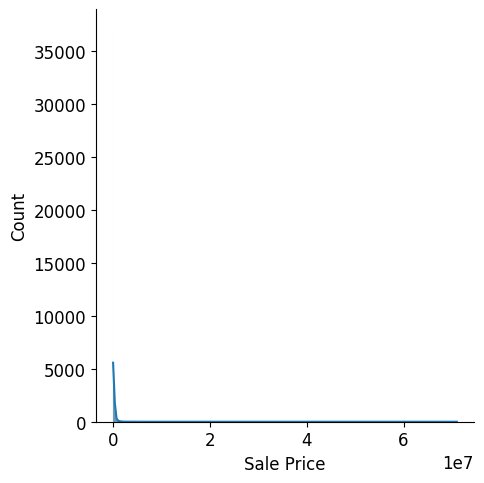

In [24]:
# Next, I'll start my analysis
label='Sale Price'

sns.displot(data=training_data, x=label, kde=True)

Our visualization seems to be ineffective due to some outliers.

In [112]:
count_above_300k = len(training_data[training_data['Sale Price'] >= 3000000]['Sale Price'])
print('There are only ' + str(count_above_300k) + ' properties with value over 300,000')
training_data['Sale Price'].describe()

There are only 250 properties with value over 300,000


count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

Outliers are usually categorized as anything 1.5 * IQR above Q3 or below Q1. The IQR is just the range between the 75th and 25th percentiles.
Lets weed them out.

In [130]:
sp_25 = training_data["Sale Price"].quantile(.25)
sp_75 = training_data['Sale Price'].quantile(.75)

iqr = sp_75-sp_25
dist= 1.5*iqr
lower = sp_25-dist
upper = sp_75+dist
print(iqr, dist, sp_25, sp_75, lower, upper)


266800.0 400200.0 45200.0 312000.0 -355000.0 712200.0


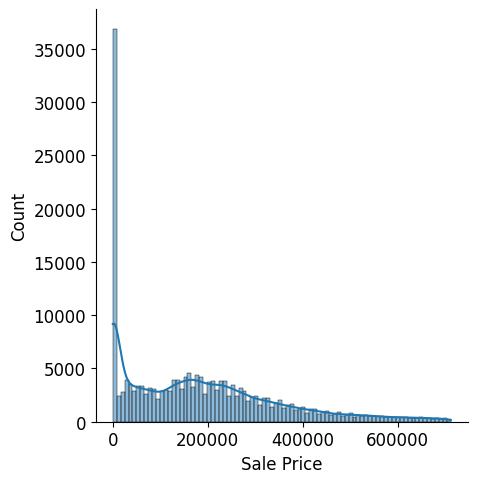

In [185]:
label='Sale Price'
outliers_removed = training_data[training_data['Sale Price'] < upper ]
sns.displot(data=outliers_removed, x=label, kde=True)

That spike looks suspicious around zero. Let's investigate it.

In [187]:
range_1_10 = outliers_removed[outliers_removed['Sale Price'] <= 10]
range_11_500 = outliers_removed[outliers_removed['Sale Price'] > 10][outliers_removed['Sale Price'] <= 500]
range_500_2000 = outliers_removed[outliers_removed['Sale Price'] > 500][outliers_removed['Sale Price'] <= 2000]
len(range_1_10), len(range_11_500), len(range_500_2000)

(35568, 305, 125)

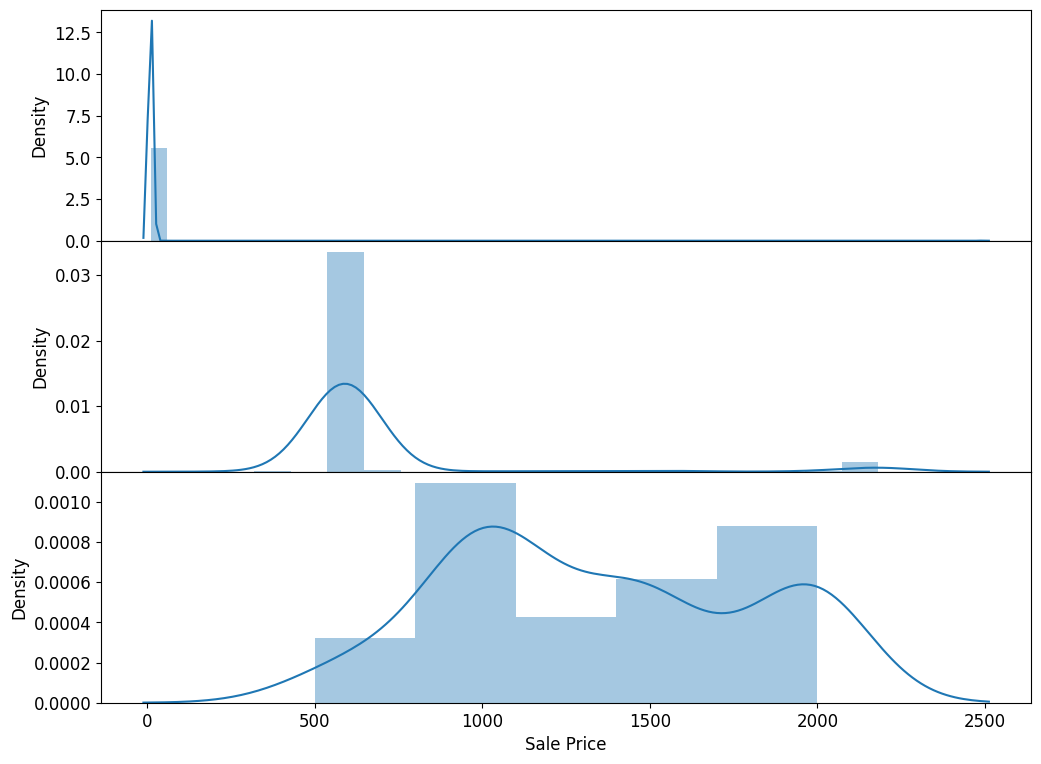

In [189]:
def plot_distribution(data1, data2, data3, label):
    fig, axs = plt.subplots(nrows=3)

    sns.distplot(data1[label], ax=axs[0])
    sns.distplot(data2[label], ax=axs[1])
    sns.distplot(data3[label], ax=axs[2])

    plt.subplots_adjust(hspace=0)

plot_distribution(range_1_10,range_11_500,range_500_2000,label)


There seems to be 35568 lots that sold for less than 10 dollars. These might be inheritences or transfers of property. We'll excluse these, and the 305 other lots that sold for less than 500 dollars. 

In [190]:
#td_upodated is our training data after removing data 1.5*IQR above Q3, and all the properties below a sales price of 500
td_upodated = outliers_removed.loc[training_data['Sale Price'] >= 500]
